# MODULE 2 Project

### Import stuff

In [3]:
import sqlite3
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')



In [5]:
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()

### Create class to access sqlite database

In [6]:
class Futball(): ### class to get total_goal, total_win, total_loss as a dataframe and for individual team
    
    def __init__(self, database, year):
        self.database = database
        self.year = year
    
    def total_goal(self):
        conn = sqlite3.Connection(self.database) #load sqlite connection
        c = conn.cursor()
        
        #selecting hometeam and sum of home goal for total home goal
        c.execute('''select m.HomeTeam as Team, Sum(FTHG) as Total_Home_Goal 
                    from Matches m
                    where Season = ''' + self.year +
                    ''' 
                    group by m.HomeTeam
                    order by HomeTeam
                    ''')
        df_home_goals = pd.DataFrame(c.fetchall())
        df_home_goals.columns = [x[0] for x in c.description]
        
        #selecting away team and sum away goal for total away goal
        c.execute('''select m.AwayTeam as Team, Sum(FTAG) as Total_Away_Goal
                    from Matches m
                    where Season = ''' + self.year +
                    '''
                    group by m.AwayTeam
                    order by m.AwayTeam
                    ''')
        df_away_goals = pd.DataFrame(c.fetchall())
        df_away_goals.columns = [x[0] for x in c.description]
        
        #add the two total home goal and total away goal columns for grand total goal and add to away Dataframe
        df_away_goals['Total Goal']= df_home_goals['Total_Home_Goal']+df_away_goals['Total_Away_Goal']
        df_away_goals.drop('Total_Away_Goal', axis =1, inplace = True) #drop total away goal and making it just total goal df
        
        return df_away_goals
    
    def goal_by_team(self, teamname): #Total Goal for individual team
        goal_df = self.total_goal() 
        return goal_df.loc[goal_df['Team'] == teamname] 
    
    def total_win(self): #same concept at total goal. get total away win and total home win and add together
        conn = sqlite3.Connection(self.database)
        c = conn.cursor()
        
        #getting total homewin
        c.execute('''select m.HomeTeam as Team, count(FTR) as HomeWin
            from Matches m
            where Season = ''' + self.year +
                    ''' and FTR = 'H'
            group by Team
            order by Team
            ''')
        df_home_win = pd.DataFrame(c.fetchall())
        df_home_win.columns = [x[0] for x in c.description]
        
        #getting total away win
        c.execute('''select m.AwayTeam as Team, count(FTR) as AwayWin
            from Matches m
            where Season = ''' + self.year +
                    ''' and FTR = 'A'
            group by Team
            order by Team
            ''')
        df_away_win = pd.DataFrame(c.fetchall())
        df_away_win.columns = [x[0] for x in c.description]
        
        #add total away win and total home win onto df away win
        df_away_win['Total Win']= df_home_win['HomeWin']+df_away_win['AwayWin']
        df_away_win.drop('AwayWin', axis =1, inplace = True) #drop away win df to make total win df
        return df_away_win
   
    def win_by_team(self, teamname): #Total Goal for individual team
        win_df = self.total_win()
        return win_df.loc[win_df['Team'] == teamname]
    
    #same concept as total win and total goal.
    def total_lose(self):
        conn = sqlite3.Connection(self.database)
        c = conn.cursor()
        
        #selecting total home loss
        c.execute('''select m.HomeTeam as Team, count(FTR) as HomeLose
            from Matches m
            where Season = ''' + self.year +
                    ''' and FTR = 'A'
            group by Team
            order by Team
            ''')
        df_home_lose = pd.DataFrame(c.fetchall())
        df_home_lose.columns = [x[0] for x in c.description]
        
        #selecting total away loss
        c.execute('''select m.AwayTeam as Team, count(FTR) as AwayLose
            from Matches m
            where Season = ''' + self.year +
                    ''' and FTR = 'H'
            group by Team
            order by Team
            ''')
        df_away_lose = pd.DataFrame(c.fetchall())
        df_away_lose.columns = [x[0] for x in c.description]
        #however, not all team lost at home, therefore making a loop to check which team 
        #never lost at home and append this to a list.
        listt = []
        for i in df_away_lose['Team']:
            if i in list(df_home_lose['Team']):
                continue
            else:
                listt.append([i,0])
        #making new dataframe to put list in
        dff = pd.DataFrame(listt,columns = ['Team', 'HomeLose'])
        #append above dataframe to df_home_lose to create full list of teams
        df_home_lose = df_home_lose.append(dff)
        df_home_lose.sort_values(by=['Team']) #sort value
        list_homelose = list(df_home_lose['HomeLose']) #list out all homelose
        for i in range(len(df_away_lose)): #loop to add homeloss to away loss to get total loss
            df_away_lose['AwayLose'][i]+=list_homelose[i]
        df_away_lose.rename(index=str, columns={"AwayLose": "Total Loss"}, inplace=True)
        return df_away_lose
    
    def loss_by_team(self, teamname): #Total Goal for individual team
        loss_df = self.total_lose()
        return loss_df.loc[loss_df['Team'] == teamname]
    
    def name_list(self):
        return list(self.total_lose()['Team'])


In [36]:
g1 = Futball('database.sqlite', '2011') #assign instance

In [37]:
namelist = g1.name_list() #get namelist

In [ ]:
namelist

In [ ]:
loss = g1.total_lose()['Total Loss'] #get loss list
loss

In [ ]:
win = g1.total_win()['Total Win'] #get win list
win

In [ ]:
goal = g1.total_goal()['Total Goal'] #get total goal list
goal

### Creating Class to access Dark Sky API

In [7]:
import pandas as pd
from dateutil import parser
import requests
import sqlite3
import datetime
import warnings
warnings.filterwarnings("ignore")

conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

c.execute("""SELECT * FROM Matches;""")
matches = pd.DataFrame(c.fetchall())
matches.columns = [x[0] for x in c.description]

# Assumed location for Berlin for the purposes of this project.

berlin_lat = '52.520008'
berlin_long = '13.404954'

api_key = ''# USE YOUR OWN, YOU MOOCH

class Weather():

    
    def __init__(self, dataframe, year, lat, long, DarkSky_API):
        self.dataframe = dataframe
        self.year = year
        self.lat = lat
        self.long = long
        self.DarkSky_API = DarkSky_API

    
    def get_rain(self):
        """Time is timestamp, everything must be a string. Returns a list of DarkSky
        information. If you've already run this before, you can comment out the API
        call and reference a local file instead to save on API calls. Otherwise comment
        out the read_csv line. Executed within the rainy_days function."""
    #     dark_sky = []
    #     for days in time:
    #         resp = requests.get('https://api.darksky.net/forecast/' + self.DarkSky_API + '/' + self.lat + ',' + self.long + ',' + days + '?exclude=flags,hourly,daily,alerts')
    #         dark_sky.append(resp.json()['currently'])
        dark_sky = pd.read_csv('weather.csv') # Comment out this line if you don't have the data already
        return dark_sky

    
    def rainy_days(self):
        gameDate = []

        for i in range(len(self.dataframe['Date'])):
            dt = parser.parse(self.dataframe['Date'][i])
            gameDate.append(dt)
        
         # Creates the DataFrame we'll use, adds the timestamped column,
        # and resets the index because we are now sorting by the year.
        # Otherwise the range(len(x)) would not work. We also create a 
        # set of unique dates for use later on.

        self.dataframe['gamedate'] = gameDate
        matches_year = matches[matches["Season"] == self.year].reset_index()
        dates = list(set(matches_year['gamedate']))

        timestamp = []
        for date in range(len(dates)):
            stamp = str(matches_year['gamedate'][date].timestamp())
            timestamp.append(stamp[:-2])
        
         # This is the Dark Sky API call. Use a csv of the data you get to
        # conserve API calls to easily stay under the 1k/day maximum. Using the
        # set created earlier, you have 6 opportunities to pull all of the dates.
        # Then we create a DataFrame of the response and filter that down to
        # the columns we need.
        
        the_rain = Weather(self.lat, self.long, 2011, timestamp, self.DarkSky_API)
            
        ds_df = pd.DataFrame(the_rain.get_rain())

        df_rain = pd.DataFrame(
            {'rainy': ds_df['icon'],
             'date': ds_df['time'],
            })
        # The Dark Sky data is in timestamp, so this brings it back to match
        # the original data, create a new dataframe of the unique dates and 
        # the rain condition.

        for day in range(len(ds_df['time'])):
            ds_df['time'][day] = datetime.datetime.utcfromtimestamp(ds_df['time'][day]).strftime('%Y-%m-%d')

        rain = pd.DataFrame(columns=['date', 'raining'])

        rain['date'] = ds_df['time']
        # Compare our unique dates in a loop and append the weather conditions.

        for i in range(len(ds_df['precipType'])):
            if ds_df['precipType'][i] == 'rain':
                rain.raining[i] = True
            else:
                rain.raining[i] = False

        rain_year = []
        for i in range(len(matches_year['Date'])):
            if matches_year['Date'][i] in list(rain.date[rain['raining'] == True]):
                rain_year.append(True)
            else:
                rain_year.append(False)

        matches_year['rain'] = rain_year
        # Creates the result, output as a dataframe with the columns mentioned earlier.

        result = matches_year[['Match_ID','Date','AwayTeam', 'HomeTeam', 'FTR', 'rain']]

        return result
    
season = Weather(matches, 2011, berlin_lat, berlin_long, api_key)
# Use this if you want a list of only the matches where it was raining.

rainy_wins = season.rainy_days()[season.rainy_days()['rain'] == True].reset_index()

rainy_wins



,index,Match_ID,Date,AwayTeam,HomeTeam,FTR,rain
0,8,1100,2011-09-18,Bayern Munich,Schalke 04,A,True
1,18,1110,2011-12-17,Dortmund,Freiburg,A,True
2,26,1118,2011-09-18,Dortmund,Hannover,H,True
3,43,1135,2012-05-06,Dresden,Frankfurt FSV,D,True
4,66,1158,2012-05-06,Duisburg,Fortuna Dusseldorf,D,True
5,76,1168,2012-05-06,Ein Frankfurt,Karlsruhe,H,True
6,127,1219,2011-08-05,Hamburg,Dortmund,H,True
7,157,1249,2011-12-09,Karlsruhe,Duisburg,H,True
8,192,1284,2011-12-17,Nurnberg,Leverkusen,A,True
9,211,1303,2011-12-09,Schalke 04,Hertha,A,True


### Creating Class for getting percentage

In [21]:
class Winning_in_the_Rain():

    """ This is meant to work hand in hand with the dataframe the function
        in weather.py produced. Outputs a dataframe with the teams as an index:
            team (index)
            wins
            appearances
            winning_rain_pct"""
    
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def get_rain_wins(self):
        raining_wins = pd.concat([self.dataframe, pd.get_dummies(self.dataframe['FTR'])], axis = 1).reset_index()
                
        away_games = pd.DataFrame(
            {'away rain games': raining_wins['AwayTeam'].value_counts()    })
        home_games = pd.DataFrame(
            {'home rain games': raining_wins['HomeTeam'].value_counts()    })

        # creates a column to indicate who won the game, and then puts the winning
        # team into the column. 'tie game' is the default.
        
        raining_wins['winner'] = 'tie game'

        for i in range(len(raining_wins['A'])):
            if raining_wins['A'][i] == 1:
                raining_wins['winner'][i] = raining_wins['AwayTeam'][i]
            if raining_wins['H'][i] == 1:
                raining_wins['winner'][i] = raining_wins['HomeTeam'][i]        

        total_wins = pd.DataFrame(
            {'wins': raining_wins['winner'].value_counts()
            })

        # add a column to tally the number of games played, calculates the winning percentages.
        
        appearances = pd.concat([away_games, home_games, total_wins], axis = 1)
        appearances['appearances'] = 0
        appearances = appearances.fillna(0)

        for i in range(len(appearances['home rain games'])):
            appearances['appearances'][i] = appearances['home rain games'][i] + appearances['away rain games'][i]

        winning_rain_pct = []
        for i in range(len(appearances['home rain games'])):
            if appearances['appearances'][i] == 0:
                winning_rain_pct.append(0)
            else:
                winning_rain_pct.append(round(float(appearances['wins'][i]) / float(appearances['appearances'][i]), 2))

        appearances['winning_rain_pct'] = winning_rain_pct

        appearances = appearances.fillna('0').drop(['home rain games', 'away rain games'], axis=1)
        return appearances

season2011 = Winning_in_the_Rain(rainy_wins)
season2011.get_rain_wins()

,wins,appearances,winning_rain_pct
Aachen,1.0,3,0.33
Aston Villa,0.0,1,0.00
Augsburg,0.0,1,0.00
Bayern Munich,1.0,1,1.00
Blackburn,0.0,1,0.00
Bochum,1.0,3,0.33
Bolton,0.0,2,0.00
Braunschweig,1.0,2,0.50
Chelsea,0.0,2,0.00
Cottbus,1.0,1,1.00


In [24]:
rain_win= season2011.get_rain_wins()

In [25]:
team_name_rain = [] #get all the teams that competed in the rain and add to list
for i in range(len(rain_win)-1):
    team_name_rain.append(rain_win.iloc[i].name)

In [26]:
team_name_rain

['Aachen',
 'Aston Villa',
 'Augsburg',
 'Bayern Munich',
 'Blackburn',
 'Bochum',
 'Bolton',
 'Braunschweig',
 'Chelsea',
 'Cottbus',
 'Dortmund',
 'Dresden',
 'Duisburg',
 'Ein Frankfurt',
 'Erzgebirge Aue',
 'Everton',
 'Fortuna Dusseldorf',
 'Frankfurt FSV',
 'Freiburg',
 'Fulham',
 'Greuther Furth',
 'Hamburg',
 'Hannover',
 'Hansa Rostock',
 'Hertha',
 'Hoffenheim',
 'Ingolstadt',
 'Karlsruhe',
 'Leverkusen',
 'Liverpool',
 'Man City',
 'Man United',
 'Munich 1860',
 'Newcastle',
 'Norwich',
 'Nurnberg',
 'Paderborn',
 'QPR',
 'Schalke 04',
 'St Pauli',
 'Stoke',
 'Stuttgart',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Union Berlin',
 'Werder Bremen',
 'West Brom',
 'Wigan',
 'Wolfsburg',
 'Wolves']

In [27]:
rain_win_percent_dict={} #putting all team in the dictionary to have all team even those 
#who didn't compete in the rain.
for i in namelist:
    if i in team_name_rain:
        rain_win_percent_dict[i] = rain_win.loc[i]['winning_rain_pct'] #if in the rain list then add name and percentge
    else:
        rain_win_percent_dict[i] = None #if not in the rain list, then added into th dict with value None

In [28]:
rain_win_percent_dict

{'Aachen': 0.33,
 'Arsenal': None,
 'Aston Villa': 0.0,
 'Augsburg': 0.0,
 'Bayern Munich': 1.0,
 'Blackburn': 0.0,
 'Bochum': 0.33,
 'Bolton': 0.0,
 'Braunschweig': 0.5,
 'Chelsea': 0.0,
 'Cottbus': 1.0,
 'Dortmund': 0.67,
 'Dresden': 0.0,
 'Duisburg': 0.5,
 'Ein Frankfurt': 0.0,
 'Erzgebirge Aue': 1.0,
 'Everton': 0.0,
 'FC Koln': None,
 'Fortuna Dusseldorf': 0.5,
 'Frankfurt FSV': 0.0,
 'Freiburg': 0.0,
 'Fulham': 0.67,
 'Greuther Furth': 0.0,
 'Hamburg': 0.0,
 'Hannover': 1.0,
 'Hansa Rostock': 0.0,
 'Hertha': 0.0,
 'Hoffenheim': 0.0,
 'Ingolstadt': 0.0,
 'Kaiserslautern': None,
 'Karlsruhe': 0.33,
 'Leverkusen': 0.0,
 'Liverpool': 0.0,
 "M'gladbach": None,
 'Mainz': None,
 'Man City': 0.5,
 'Man United': 1.0,
 'Munich 1860': 0.75,
 'Newcastle': 0.0,
 'Norwich': 0.0,
 'Nurnberg': 1.0,
 'Paderborn': 0.5,
 'QPR': 1.0,
 'Schalke 04': 0.67,
 'St Pauli': 1.0,
 'Stoke': 0.33,
 'Stuttgart': 0.0,
 'Sunderland': 0.5,
 'Swansea': 0.0,
 'Tottenham': 0.5,
 'Union Berlin': 0.5,
 'Werder Bremen'

In [29]:
rain_win_percent_dict['Aachen']

0.33

In [38]:
import pymongo

In [39]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['team_database'] #initializing

In [40]:
mydb

Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'team_database')

In [41]:
ls

Football Weather Final.ipynb
Get Weather and Rain Wins Percentage.ipynb
database.sqlite*
football.ipynb
rainy_wins.py
weather.csv
weather.py


In [42]:
mycollection = mydb['team_collection'] #assigning collection

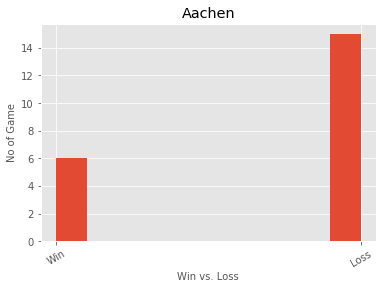

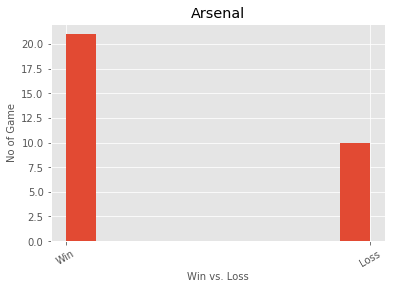

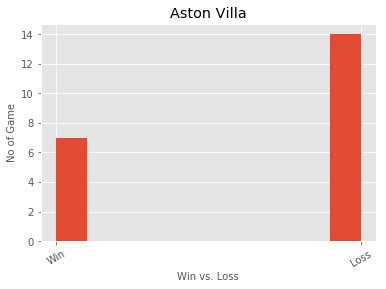

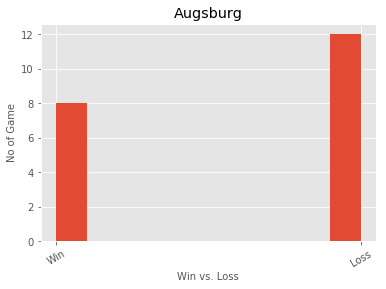

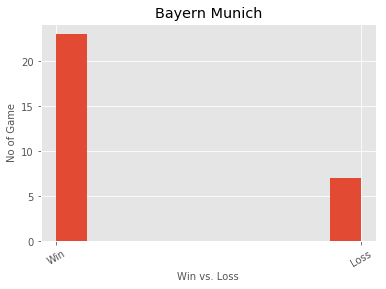

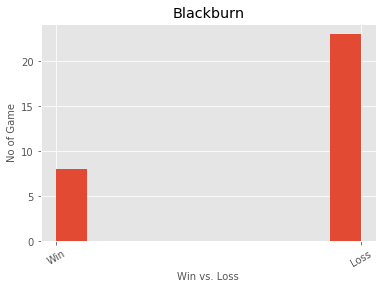

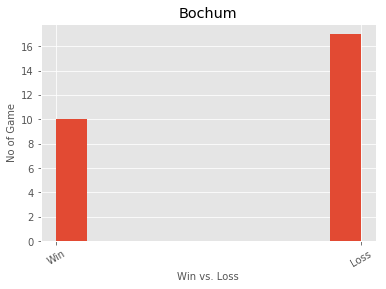

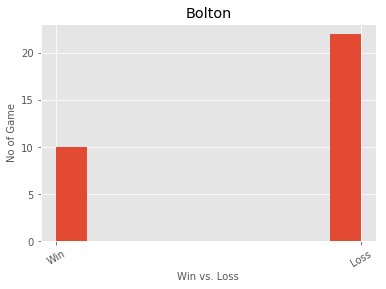

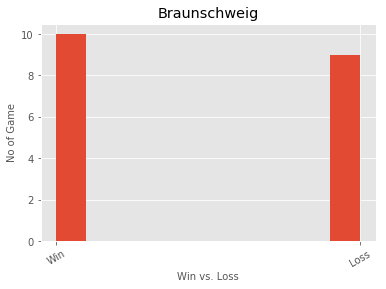

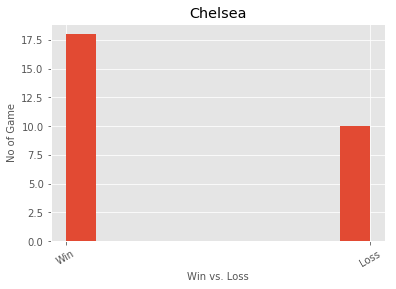

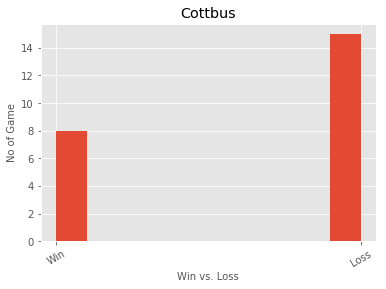

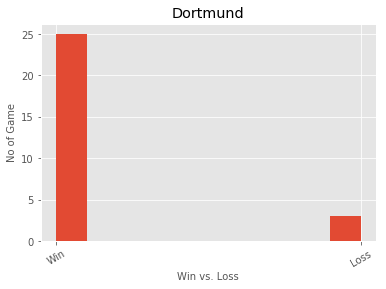

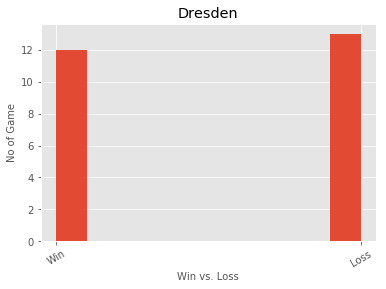

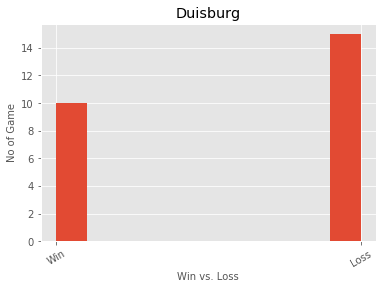

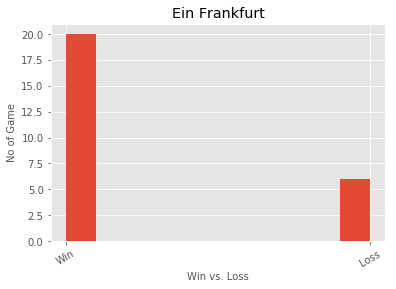

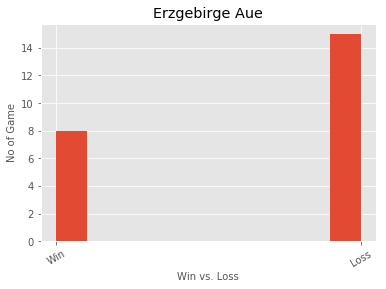

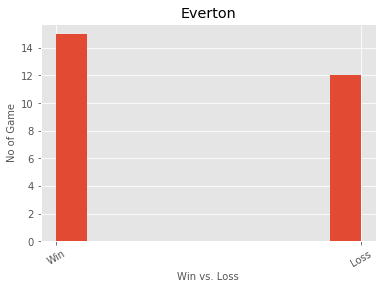

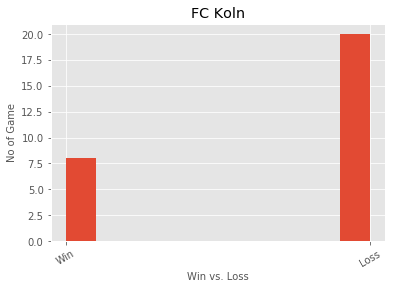

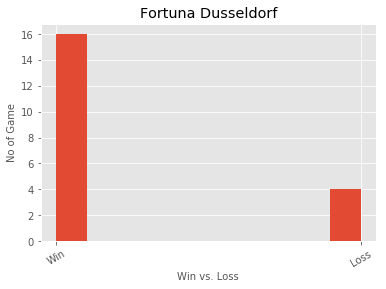

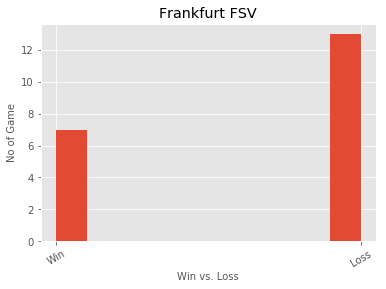

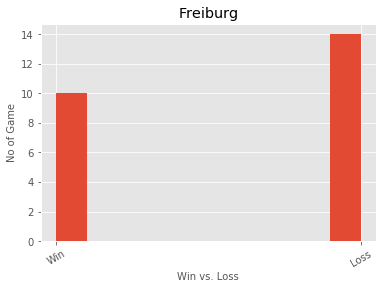

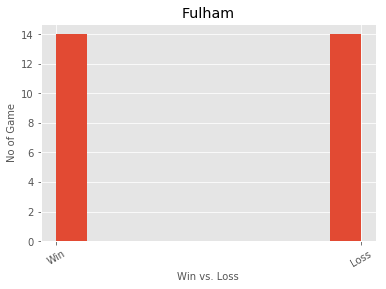

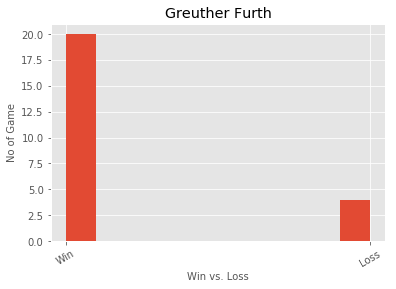

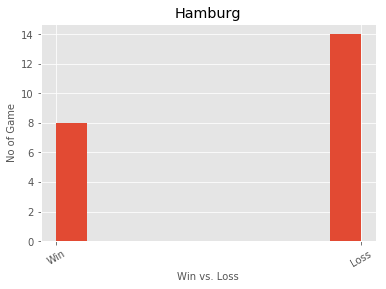

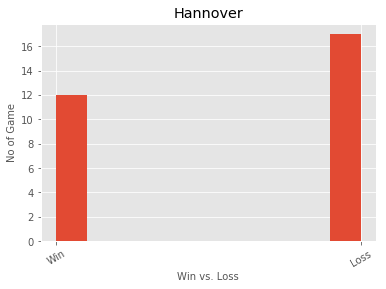

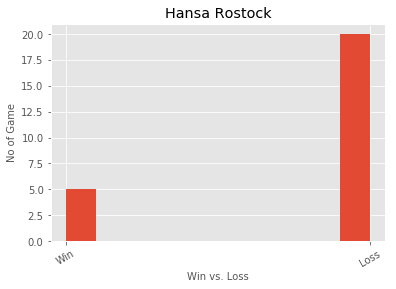

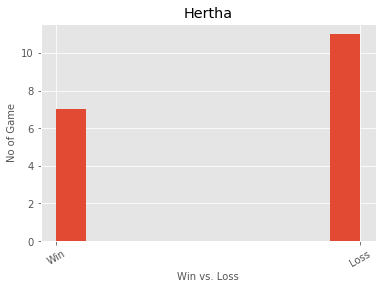

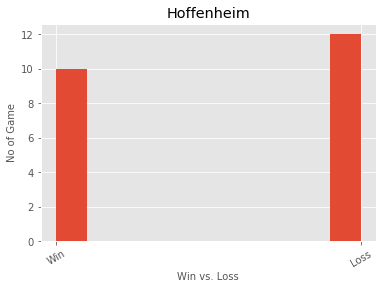

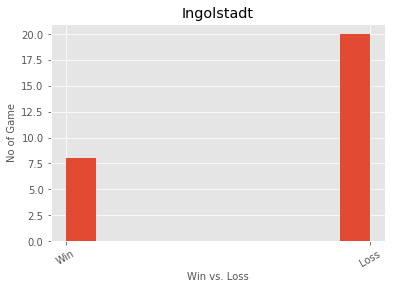

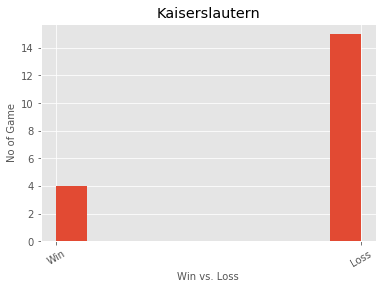

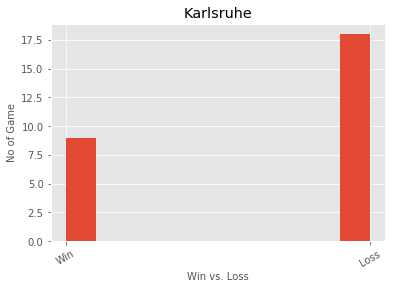

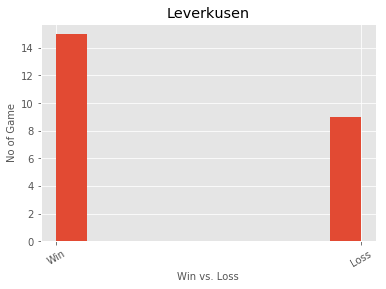

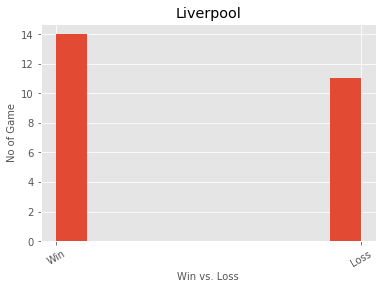

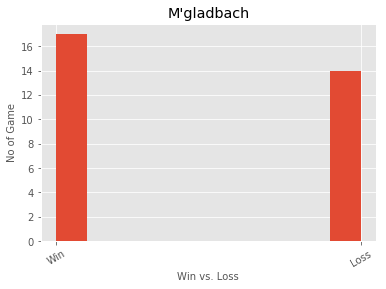

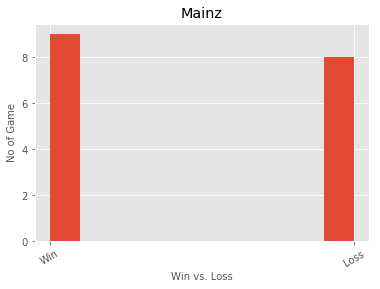

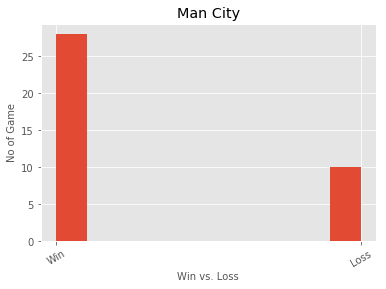

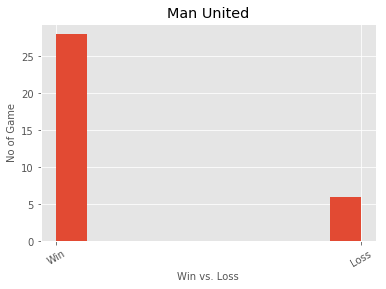

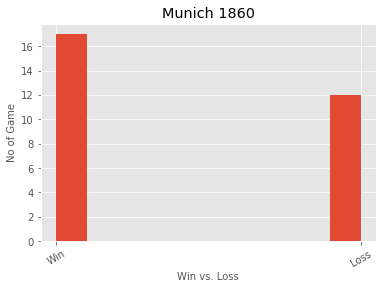

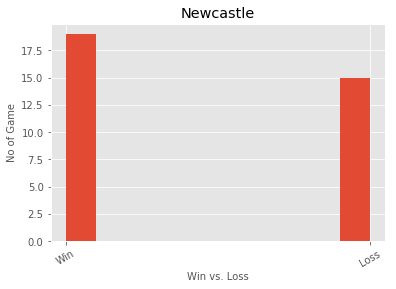

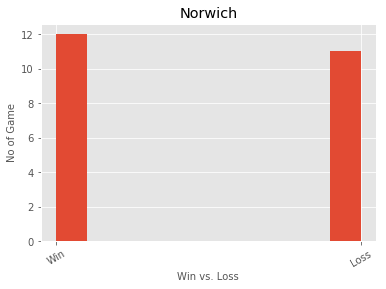

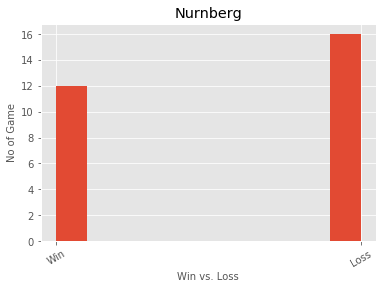

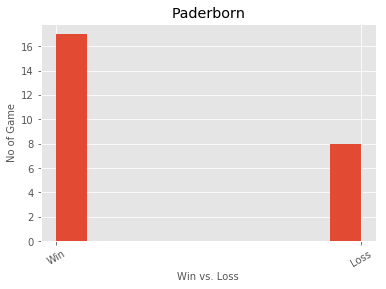

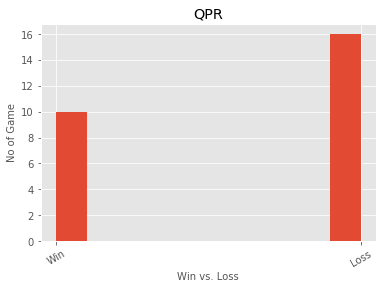

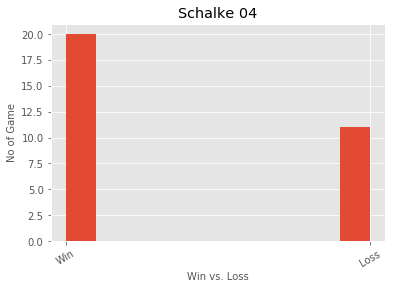

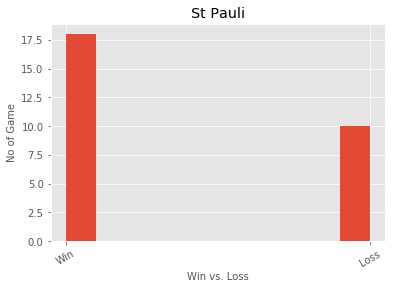

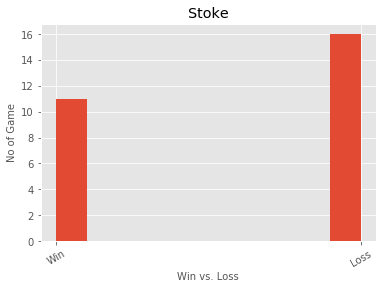

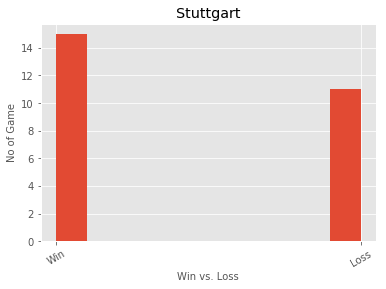

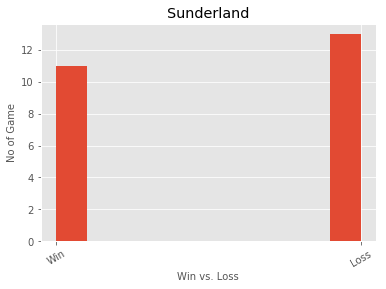

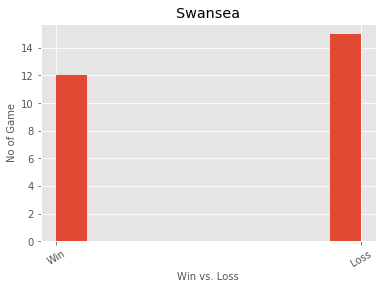

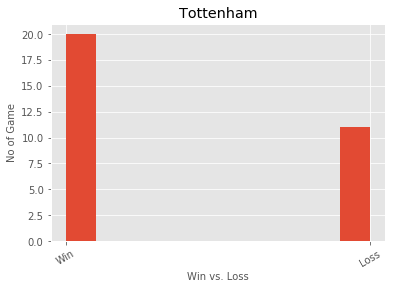

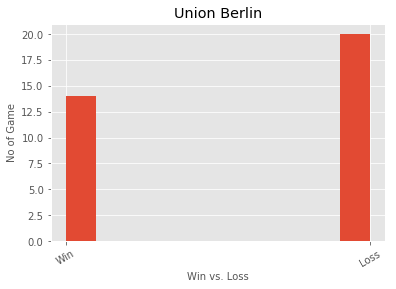

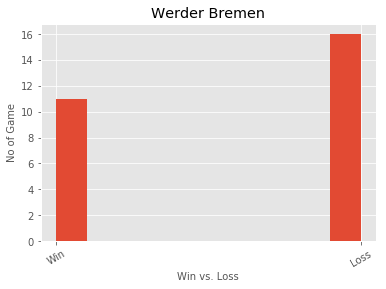

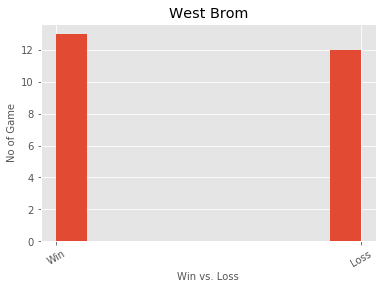

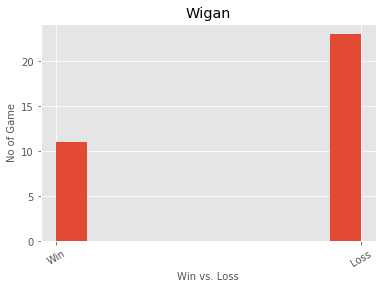

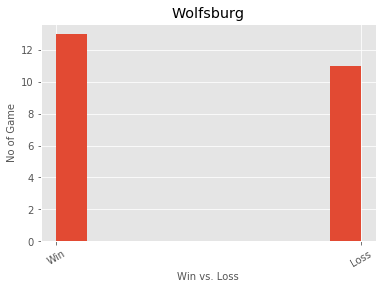

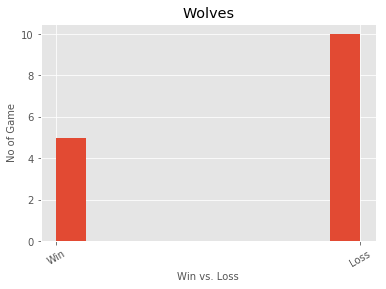

In [127]:
bar_obj=[] #attempted to make a list of bar object but couldn't insert in mongodb
for i in range(len(namelist)): #making all graphs with this loop
    win_bar = int(g1.win_by_team(namelist[i])['Total Win'])
    loss_bar = int(g1.loss_by_team(namelist[i])['Total Loss'])
    win_loss = win_bar*['Win']+ loss_bar*['Loss']
    bar_obj.append(plt.hist(win_loss)) #append into list of bar obj
    plt.xlabel('Win vs. Loss', fontsize=10) #visualization
    plt.ylabel('No of Game', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title(namelist[i])
    plt.show()
    

In [227]:
list_of_team = [] #making list of team with all required info without graph
for i in range(len(namelist)):
    list_of_team.append({'name': namelist[i], 'total goal': int(goal[i]), 'total win': int(win[i]), 'rain win %': rain_win_percent_dict[namelist[i]], 'total loss': int(loss[i]), 'graph':'ALMOST IMPOSSIBLE TO DO.'})


    
        

In [228]:
list_of_team 

[{'name': 'Aachen',
  'total goal': 30,
  'total win': 6,
  'rain win %': 0.33,
  'total loss': 15,
  'graph': 'ALMOST IMPOSSIBLE TO DO.'},
 {'name': 'Arsenal',
  'total goal': 74,
  'total win': 21,
  'rain win %': None,
  'total loss': 10,
  'graph': 'ALMOST IMPOSSIBLE TO DO.'},
 {'name': 'Aston Villa',
  'total goal': 37,
  'total win': 7,
  'rain win %': 0.0,
  'total loss': 14,
  'graph': 'ALMOST IMPOSSIBLE TO DO.'},
 {'name': 'Augsburg',
  'total goal': 36,
  'total win': 8,
  'rain win %': 0.0,
  'total loss': 12,
  'graph': 'ALMOST IMPOSSIBLE TO DO.'},
 {'name': 'Bayern Munich',
  'total goal': 77,
  'total win': 23,
  'rain win %': 1.0,
  'total loss': 7,
  'graph': 'ALMOST IMPOSSIBLE TO DO.'},
 {'name': 'Blackburn',
  'total goal': 48,
  'total win': 8,
  'rain win %': 0.0,
  'total loss': 23,
  'graph': 'ALMOST IMPOSSIBLE TO DO.'},
 {'name': 'Bochum',
  'total goal': 41,
  'total win': 10,
  'rain win %': 0.33,
  'total loss': 17,
  'graph': 'ALMOST IMPOSSIBLE TO DO.'},
 {'n

In [177]:
result =  mycollection.insert_many(list_of_team) #insert list into mongodb

In [174]:
result.inserted_ids

[ObjectId('5ce45fda61ebb3519beb1eb8'),
 ObjectId('5ce45fda61ebb3519beb1eb9'),
 ObjectId('5ce45fda61ebb3519beb1eba'),
 ObjectId('5ce45fda61ebb3519beb1ebb'),
 ObjectId('5ce45fda61ebb3519beb1ebc'),
 ObjectId('5ce45fda61ebb3519beb1ebd'),
 ObjectId('5ce45fda61ebb3519beb1ebe'),
 ObjectId('5ce45fda61ebb3519beb1ebf'),
 ObjectId('5ce45fda61ebb3519beb1ec0'),
 ObjectId('5ce45fda61ebb3519beb1ec1'),
 ObjectId('5ce45fda61ebb3519beb1ec2'),
 ObjectId('5ce45fda61ebb3519beb1ec3'),
 ObjectId('5ce45fda61ebb3519beb1ec4'),
 ObjectId('5ce45fda61ebb3519beb1ec5'),
 ObjectId('5ce45fda61ebb3519beb1ec6'),
 ObjectId('5ce45fda61ebb3519beb1ec7'),
 ObjectId('5ce45fda61ebb3519beb1ec8'),
 ObjectId('5ce45fda61ebb3519beb1ec9'),
 ObjectId('5ce45fda61ebb3519beb1eca'),
 ObjectId('5ce45fda61ebb3519beb1ecb'),
 ObjectId('5ce45fda61ebb3519beb1ecc'),
 ObjectId('5ce45fda61ebb3519beb1ecd'),
 ObjectId('5ce45fda61ebb3519beb1ece'),
 ObjectId('5ce45fda61ebb3519beb1ecf'),
 ObjectId('5ce45fda61ebb3519beb1ed0'),
 ObjectId('5ce45fda61ebb3